In [1]:
from efficientnet.keras import EfficientNetB3

Using TensorFlow backend.


In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, applications
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras import backend as K 

In [6]:
train_dir = './train/train'
train_resize_dir = './train/resize_300_train'
#train_dir_cats = './kaggle_dogcat/train/cats'
test_dir = './test/test/'
test_resize_dir = './test/resize_300_test'

df = pd.read_csv('resize_300.csv', dtype=str)  
df['filename_resize'] = train_resize_dir +'/'+ df['category'] +'/'+ df['filename']
df['filename_oringal'] = train_dir +'/'+ df['category'] +'/'+ df['filename']
df.head()

filename category  \
0  13ccab997a3cc093dc4aeb407e7a07e9.jpg       26   
1  141123451fb8e886ecdcb9dbd2c77b4a.jpg       39   
2  2cb55abf12a3376f7c174a10a2a82ae9.jpg       05   
3  498ad71587266a7779aeba2b91654e3c.jpg       12   
4  9c4ac0aec4f39670a9dd35f146e78499.jpg       20   

                                     filename_resize  \
0  ./train/resize_300_train/26/13ccab997a3cc093dc...   
1  ./train/resize_300_train/39/141123451fb8e886ec...   
2  ./train/resize_300_train/05/2cb55abf12a3376f7c...   
3  ./train/resize_300_train/12/498ad71587266a7779...   
4  ./train/resize_300_train/20/9c4ac0aec4f39670a9...   

                                    filename_oringal  
0  ./train/train/26/13ccab997a3cc093dc4aeb407e7a0...  
1  ./train/train/39/141123451fb8e886ecdcb9dbd2c77...  
2  ./train/train/05/2cb55abf12a3376f7c174a10a2a82...  
3  ./train/train/12/498ad71587266a7779aeba2b91654...  
4  ./train/train/20/9c4ac0aec4f39670a9dd35f146e78...

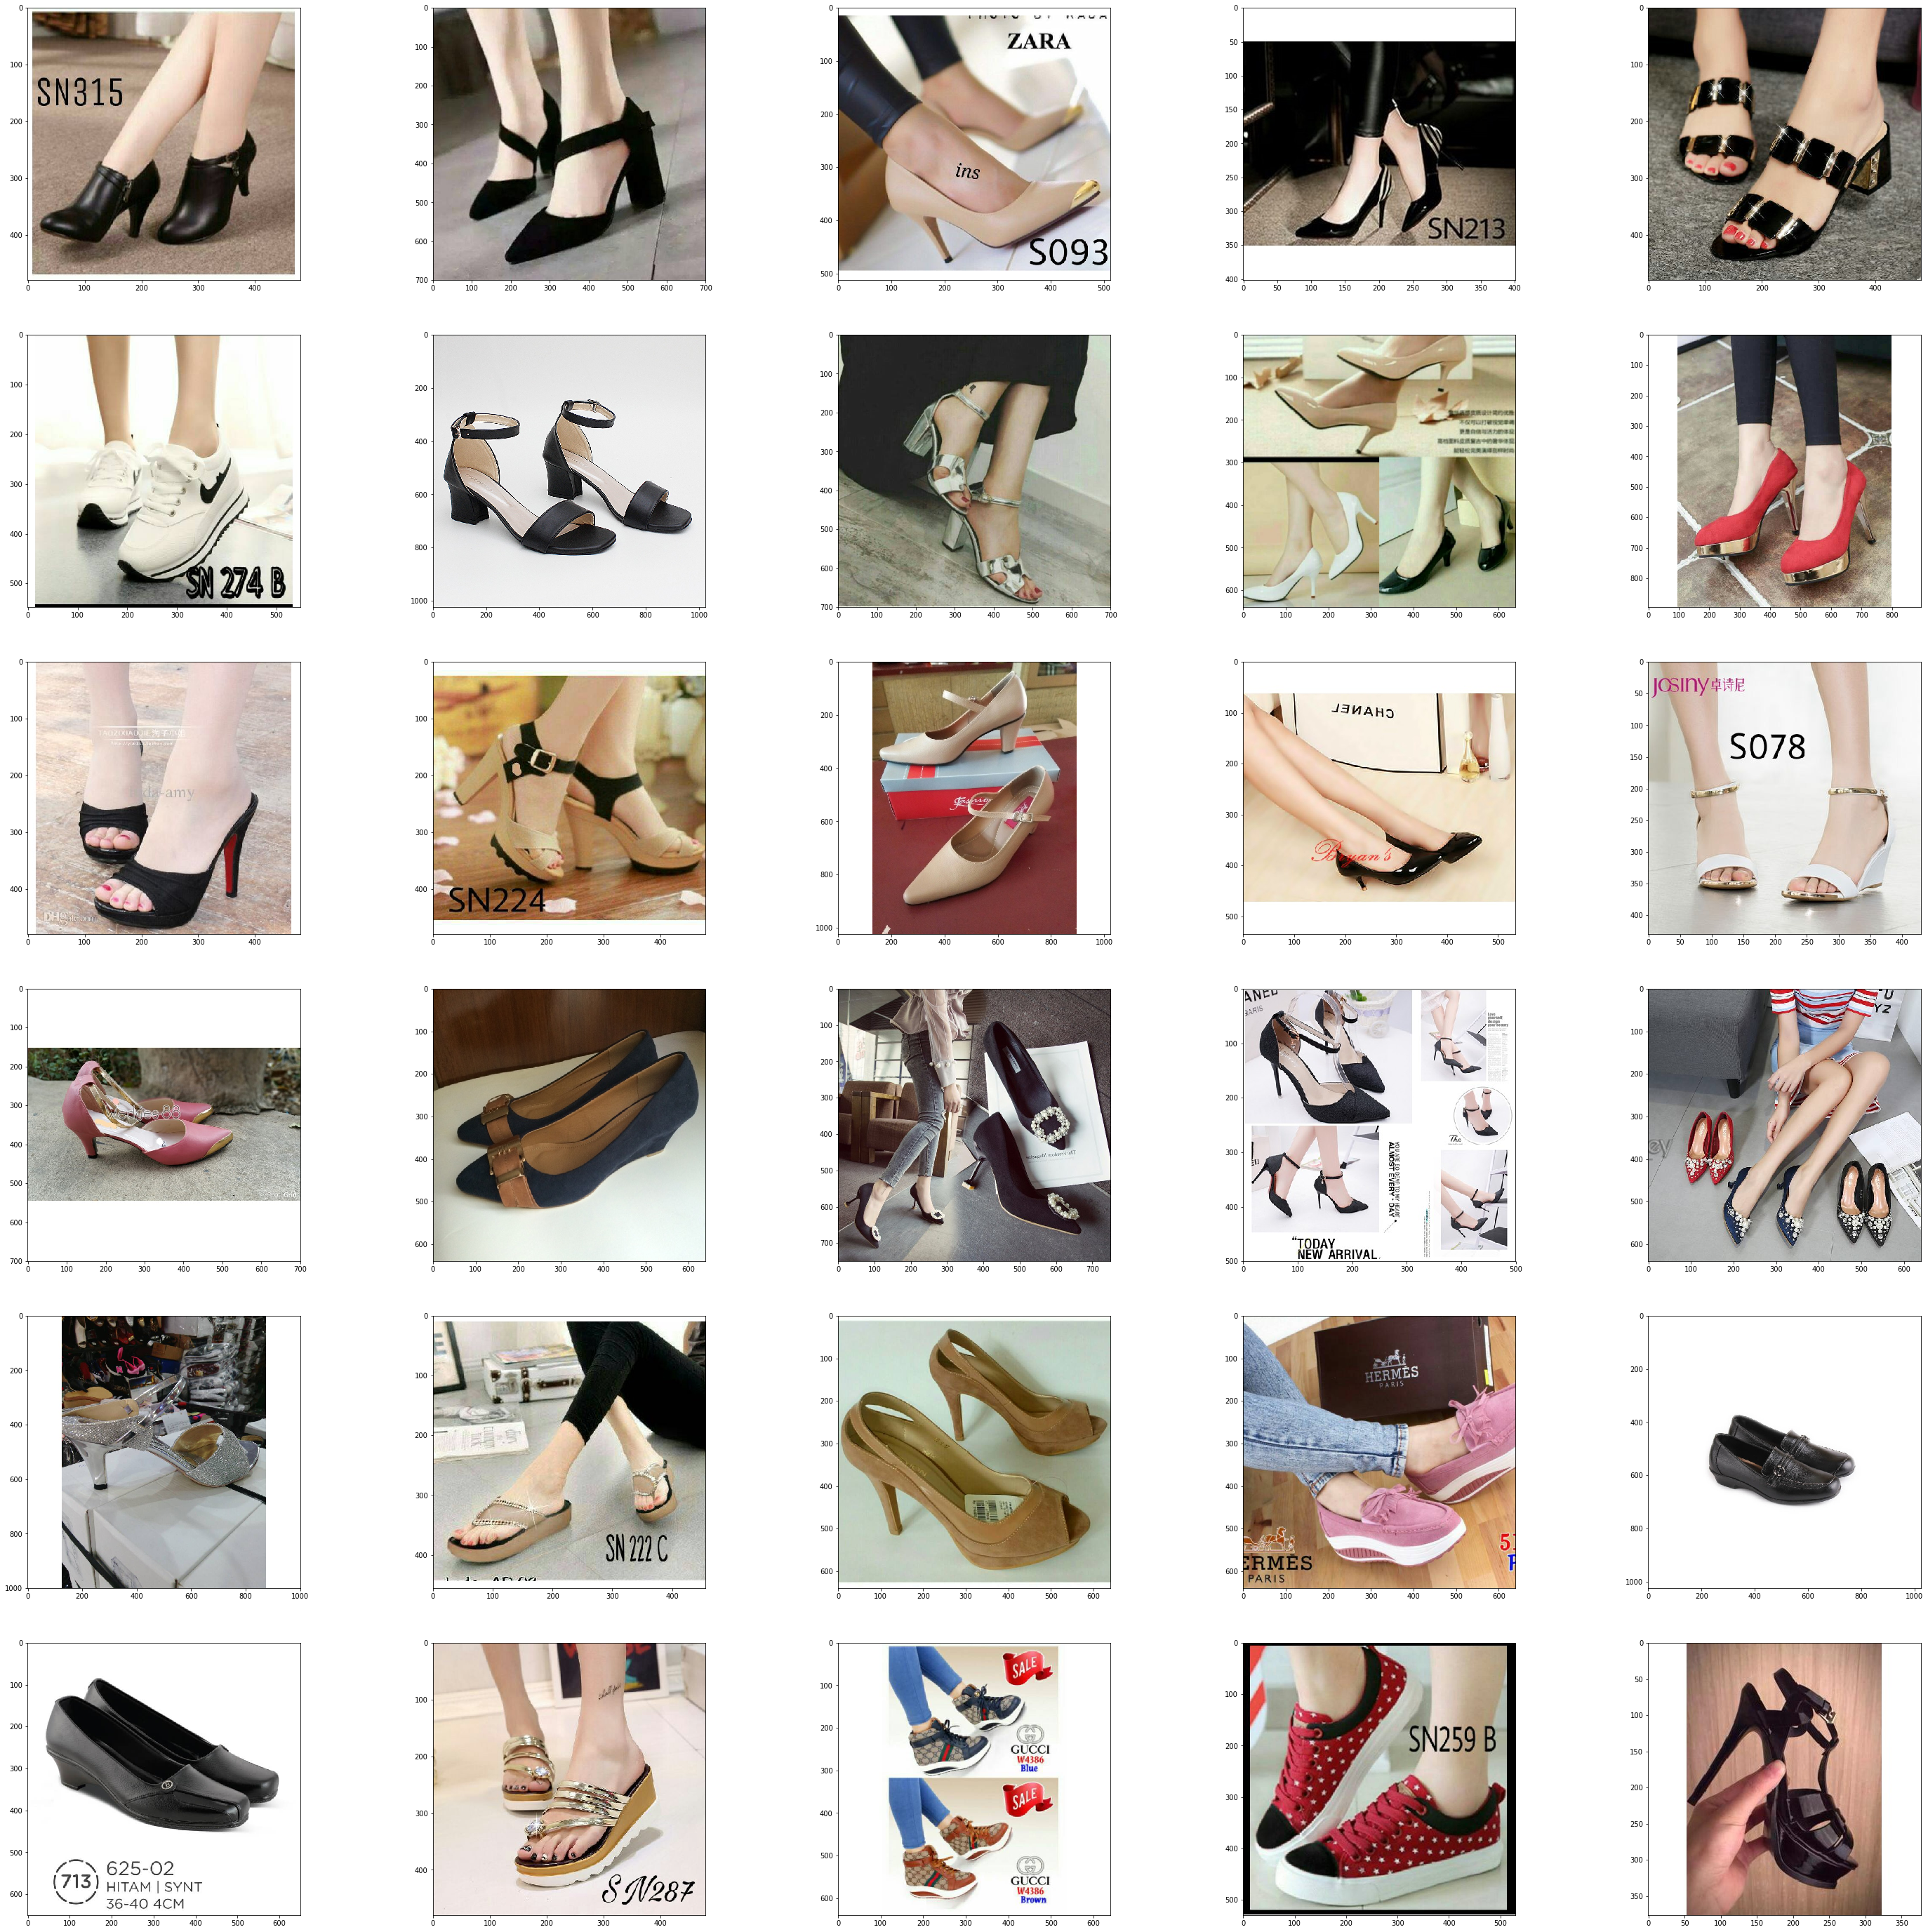

In [75]:
# Example of images for category = 
img_names = df[df['category']=='17']['filename_resize'][:30]
#print(img_names)
plt.figure(figsize=[50,50])
i = 1
for img_name in img_names:
    img = cv2.imread(img_name)[...,[2, 1, 0]]
    plt.subplot(6, 5, i)
    plt.imshow(img)
    i += 1
plt.show()

In [36]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image

import matplotlib.pyplot as plt
from keras.utils import to_categorical

imgSize = 300
i=0
X_train = []
Y_train = []

for imagePath in (df['filename_resize'].head(10000)):
    #label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #image = cv2.resize(image, (imgSize, imgSize))

    X_train.append(image)
    Y_train.append(df['category'][i])
    i=i+1
    
X_train = np.asarray(X_train).astype('float16')/255
Y_train = to_categorical(Y_train)
print("Shape of train images is:", X_train.shape)
print("Shape of labels is:", Y_train.shape)

Shape of train images is: (10000, 300, 300, 3)
Shape of labels is: (10000, 42)


In [37]:
#Lets split the data into train and test set
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.20, random_state=2)

In [62]:
nb_classes = 42
batch_size = 256
img_size = 96
nb_epochs = 10

In [63]:
%%time
train_datagen=ImageDataGenerator(rescale=1./255, 
    validation_split=0.25,
    horizontal_flip = True,    
    zoom_range = 0.3,
    width_shift_range = 0.3,
    height_shift_range=0.3
    )

train_generator=train_datagen.flow_from_dataframe(    
    dataframe=df,    
    directory="./",
    labels='inferred',
    x_col="filename_resize",
    y_col="category",
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",    
    target_size=(img_size,img_size))

Found 105392 validated image filenames belonging to 42 classes.
CPU times: user 815 ms, sys: 153 ms, total: 967 ms
Wall time: 965 ms


Found 12186 validated image filenames belonging to 1 classes.
CPU times: user 113 ms, sys: 12.1 ms, total: 125 ms
Wall time: 124 ms


In [65]:
model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

In [66]:
model.trainable = False

In [67]:
#Adding custom layers 
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(nb_classes, activation="softmax")(x)
model_final = Model(input = model.input, output = predictions)

model_final.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),loss='categorical_crossentropy',metrics=['accuracy'])

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [68]:
# Callbacks

checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

In [69]:
%%time
history = model_final.fit_generator(generator=train_generator,  
                                    steps_per_epoch=5,
                                    validation_data=valid_generator, 
                                    validation_steps=2,
                                    epochs=nb_epochs,
                                    callbacks = [checkpoint, early],
                                    verbose=2)

Epoch 1/10


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[256,2304,3,3] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node block7b_expand_conv_1/convolution}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[metrics_1/acc/Mean/_8983]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[256,2304,3,3] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node block7b_expand_conv_1/convolution}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

In [70]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

NameError: name 'history' is not defined

In [ ]:
%%time
test_generator.reset()
predict=model_final.predict_generator(test_generator, steps = len(test_generator.filenames))

In [ ]:
%%time
df_test = pd.read_csv('test.csv', dtype=str)  
#print (df_test)
test_datagen = ImageDataGenerator(rescale=1./255)
valid_generator=test_datagen.flow_from_dataframe(    
    dataframe=df_test,    
    directory="./test/test/",
    labels='inferred',
    x_col="filename",
    y_col="category",
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",    
    target_size=(img_size,img_size))